In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class ChebyshevKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyshevKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def chebyshev_polynomials(self, x):
        T = [torch.ones_like(x), x]
        for n in range(2, self.degree + 1):
            T.append(2 * x * T[n - 1] - T[n - 2])
        return torch.stack(T, dim=-1)

    def forward(self, x):
        x = x.view(-1, self.inputdim)
        x = 2 * (x - x.min(dim=1, keepdim=True)[0]) / (x.max(dim=1, keepdim=True)[0] - x.min(dim=1, keepdim=True)[0]) - 1
        T = self.chebyshev_polynomials(x)
        y = torch.einsum("bij,ioj->bo", T, self.cheby_coeffs)
        y = y.view(-1, self.outdim)
        return y

class ChebyshevKANAutoencoder(nn.Module):
    def __init__(self, degree):
        super(ChebyshevKANAutoencoder, self).__init__()
        self.encoder = ChebyshevKANLayer(28 * 28, 64, degree)
        self.decoder = ChebyshevKANLayer(64, 28 * 28, degree)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.relu(self.encoder(x))
        decoded = self.sigmoid(self.decoder(encoded))
        return encoded, decoded.view(-1, 1, 28, 28)

# Hyperparameters
learning_rate = 0.001
batch_size = 128
degree = 2
epochs = 50

# Data loading and transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, criterion, and optimizer
model = ChebyshevKANAutoencoder(degree).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5364468.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 156037.15it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1269676.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2746616.03it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        encoded, decoded = model(data)
        loss = criterion(decoded, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Training loop
train_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}')

Epoch 1, Train Loss: 0.0463
Epoch 2, Train Loss: 0.0264
Epoch 3, Train Loss: 0.0212
Epoch 4, Train Loss: 0.0186
Epoch 5, Train Loss: 0.0170
Epoch 6, Train Loss: 0.0160
Epoch 7, Train Loss: 0.0152
Epoch 8, Train Loss: 0.0147
Epoch 9, Train Loss: 0.0142
Epoch 10, Train Loss: 0.0139
Epoch 11, Train Loss: 0.0136
Epoch 12, Train Loss: 0.0134
Epoch 13, Train Loss: 0.0132
Epoch 14, Train Loss: 0.0130
Epoch 15, Train Loss: 0.0129
Epoch 16, Train Loss: 0.0127
Epoch 17, Train Loss: 0.0126
Epoch 18, Train Loss: 0.0125
Epoch 19, Train Loss: 0.0124
Epoch 20, Train Loss: 0.0123
Epoch 21, Train Loss: 0.0123
Epoch 22, Train Loss: 0.0122
Epoch 23, Train Loss: 0.0121
Epoch 24, Train Loss: 0.0121
Epoch 25, Train Loss: 0.0120
Epoch 26, Train Loss: 0.0120
Epoch 27, Train Loss: 0.0119
Epoch 28, Train Loss: 0.0119
Epoch 29, Train Loss: 0.0118
Epoch 30, Train Loss: 0.0118
Epoch 31, Train Loss: 0.0117
Epoch 32, Train Loss: 0.0117
Epoch 33, Train Loss: 0.0117
Epoch 34, Train Loss: 0.0117
Epoch 35, Train Loss: 0

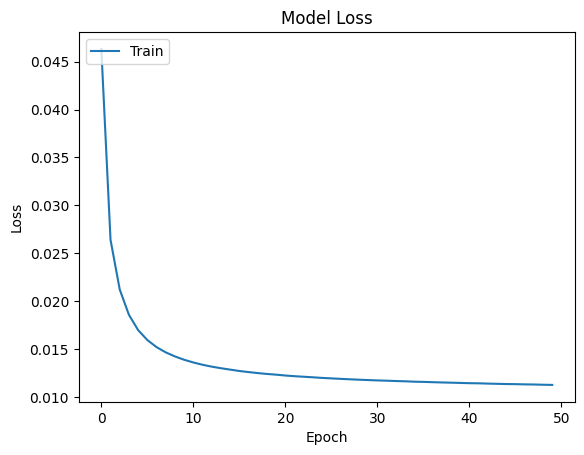

In [3]:
plt.plot(train_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


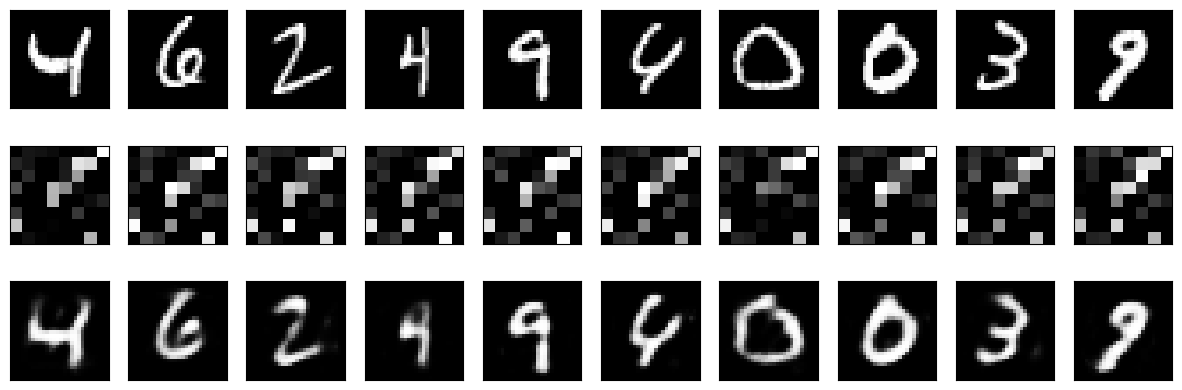

In [4]:
# Function to display results
def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8, 8)):
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(28, 28,))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(28, 28,))

def display_one_row(disp_images, offset, shape=(28, 28)):
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        test_image = test_image.cpu().numpy().reshape(shape)
        plt.imshow(test_image, cmap='gray')

# Sample data from test_loader
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)

# Get encoded and decoded images
model.eval()
with torch.no_grad():
    encoded, decoded = model(images)

# Select a few random samples for visualization
idxs = np.random.choice(images.size(0), size=10, replace=False)
disp_input_images = images[idxs]
disp_encoded = encoded[idxs]
disp_predicted = decoded[idxs]

display_results(disp_input_images, disp_encoded, disp_predicted)